# **Introduction**
In this notebook we will walkthrough detailed statistical analysis of Titanic data set along with Machine learning model implementation. 

Emplearemos algoritmos de clasificación para intentar estimar si una persona sobrevive o no al Titanic.

The Titanic dataset, often referred to as "titanic.csv," is a popular dataset used for teaching and practicing machine learning techniques. It contains data on passengers aboard the RMS Titanic, which famously sank after hitting an iceberg on its maiden voyage in 1912. The dataset typically includes various features (columns) that describe each passenger, along with a target variable indicating whether the passenger survived or not.

Here are the common features found in the Titanic dataset:

1. **PassengerId**: A unique identifier for each passenger.

2. **Survived**: This is the target variable. It indicates whether a passenger survived (1) or not (0).

3. **Pclass**: The ticket class of the passenger, which represents the socio-economic status. It's a categorical variable with three levels: 1st class, 2nd class, and 3rd class.

4. **Name**: The name of the passenger. It includes the title as well (e.g., Mr., Mrs., Miss).

5. **Sex**: The gender of the passenger, typically categorized as male or female.

6. **Age**: The age of the passenger. It is represented as a numeric value. Note that this feature may contain missing values.

7. **SibSp**: The number of siblings/spouses aboard the Titanic.

8. **Parch**: The number of parents/children aboard the Titanic.

9. **Ticket**: The ticket number of the passenger.

10. **Fare**: The fare (ticket price) paid by the passenger.

11. **Cabin**: The cabin number of the passenger. This feature may contain missing values.

12. **Embarked**: The port of embarkation for the passenger. It's a categorical variable with three levels: C = Cherbourg, Q = Queenstown, S = Southampton.

These features can be used to predict the likelihood of survival for passengers based on various characteristics such as their socio-economic status, age, gender, etc. Machine learning models can be trained on this dataset to predict whether a given passenger would have survived the Titanic disaster based on these features.


# **Table of Contents**
* [Setting up the environment](#1)
* [Importing Libraries](#2)
* [Reading the data](#3)
* [Exploratory Data Analysis](#4)
* [Feature Engineering](#5)
* [Spark ML Models](#6)
* [Submitting the predictions](#7)

<a id='1'></a>
# **Setting up the environment**
Before starting we first have to change the java version of the notebook because if we will use version 11 which is already installed then we will get some errors and we will not be able to use pyspark properly. So we will delete java version 11 and install java version 8.

! apt remove -y openjdk-11-jre-headless

!apt-get update

!apt install -y openjdk-8-jdk openjdk-8-jre

**If you get this error "E: Failed to fetch http://archive.ubuntu.com/ubuntu/pool/main/p/pulseaudio/libpulse0_11.1-1ubuntu7.5_amd64.deb  404  Not Found [IP: 91.189.88.142 80]" while installing java version 8 then run "!apt-get update" this command first like I did and then install jdk8.**

In [2]:
!java -version

java version "17.0.10" 2024-01-16 LTS
Java(TM) SE Runtime Environment (build 17.0.10+11-LTS-240)
Java HotSpot(TM) 64-Bit Server VM (build 17.0.10+11-LTS-240, mixed mode, sharing)


**After installing jdk8, we will now install pyspark.**

In [3]:
!pip install pyspark

     ---------------------------------------- 0.0/317.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/317.0 MB ? eta -:--:--
     ---------------------------------------- 0.1/317.0 MB 1.4 MB/s eta 0:03:40
     ---------------------------------------- 0.6/317.0 MB 4.7 MB/s eta 0:01:08
     ---------------------------------------- 0.8/317.0 MB 5.4 MB/s eta 0:00:59
     ---------------------------------------- 0.9/317.0 MB 4.2 MB/s eta 0:01:16
     ---------------------------------------- 1.4/317.0 MB 5.1 MB/s eta 0:01:03
     ---------------------------------------- 1.7/317.0 MB 5.3 MB/s eta 0:01:00
     ---------------------------------------- 2.3/317.0 MB 6.7 MB/s eta 0:00:47
     ---------------------------------------- 2.9/317.0 MB 7.2 MB/s eta 0:00:44
     ---------------------------------------- 3.5/317.0 MB 7.7 MB/s eta 0:00:41
      --------------------------------------- 4.0/317.0 MB 8.0 MB/s eta 0:00:39
      --------------------------------------- 4.6/317.

<a id='2'></a>
# **Importing Libraries**

In [4]:
import os
import pandas as pd
import numpy as np
import re
from pylab import *
from pyspark.sql.functions import udf, concat, col, lit
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F

#Creating spark session
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .getOrCreate()
sqlContext = SQLContext(sc)

from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\juan\anaconda3\envs\spark\Lib\site-packages\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


<a id='3'></a>
# **Reading the data**

In [6]:

df1 = pd.read_csv('input/train.csv')
df2 = pd.read_csv('input/test.csv')
sub_df = pd.read_csv('input/gender_submission.csv')

In [7]:
df1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<a id='4'></a>
# **Exploratory Data Analysis**

**Let us first see how many people survived or not.**

Number of passengers didn't Survived = 549
Number of passengers survived = 342


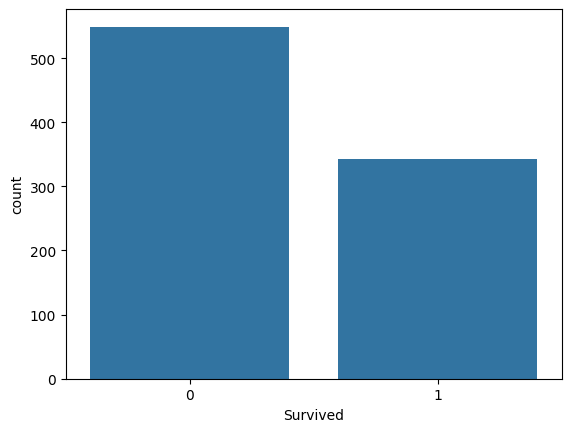

In [8]:
survival = df1.groupby('Survived').count()['Name'].reset_index()
sns.countplot(x='Survived', data=df1)
print("Number of passengers didn't Survived = {}".format(survival['Name'][0]))
print("Number of passengers survived = {}".format(survival['Name'][1]))

**Now we will observe how each factor has its impact on whether the person survived or not.**

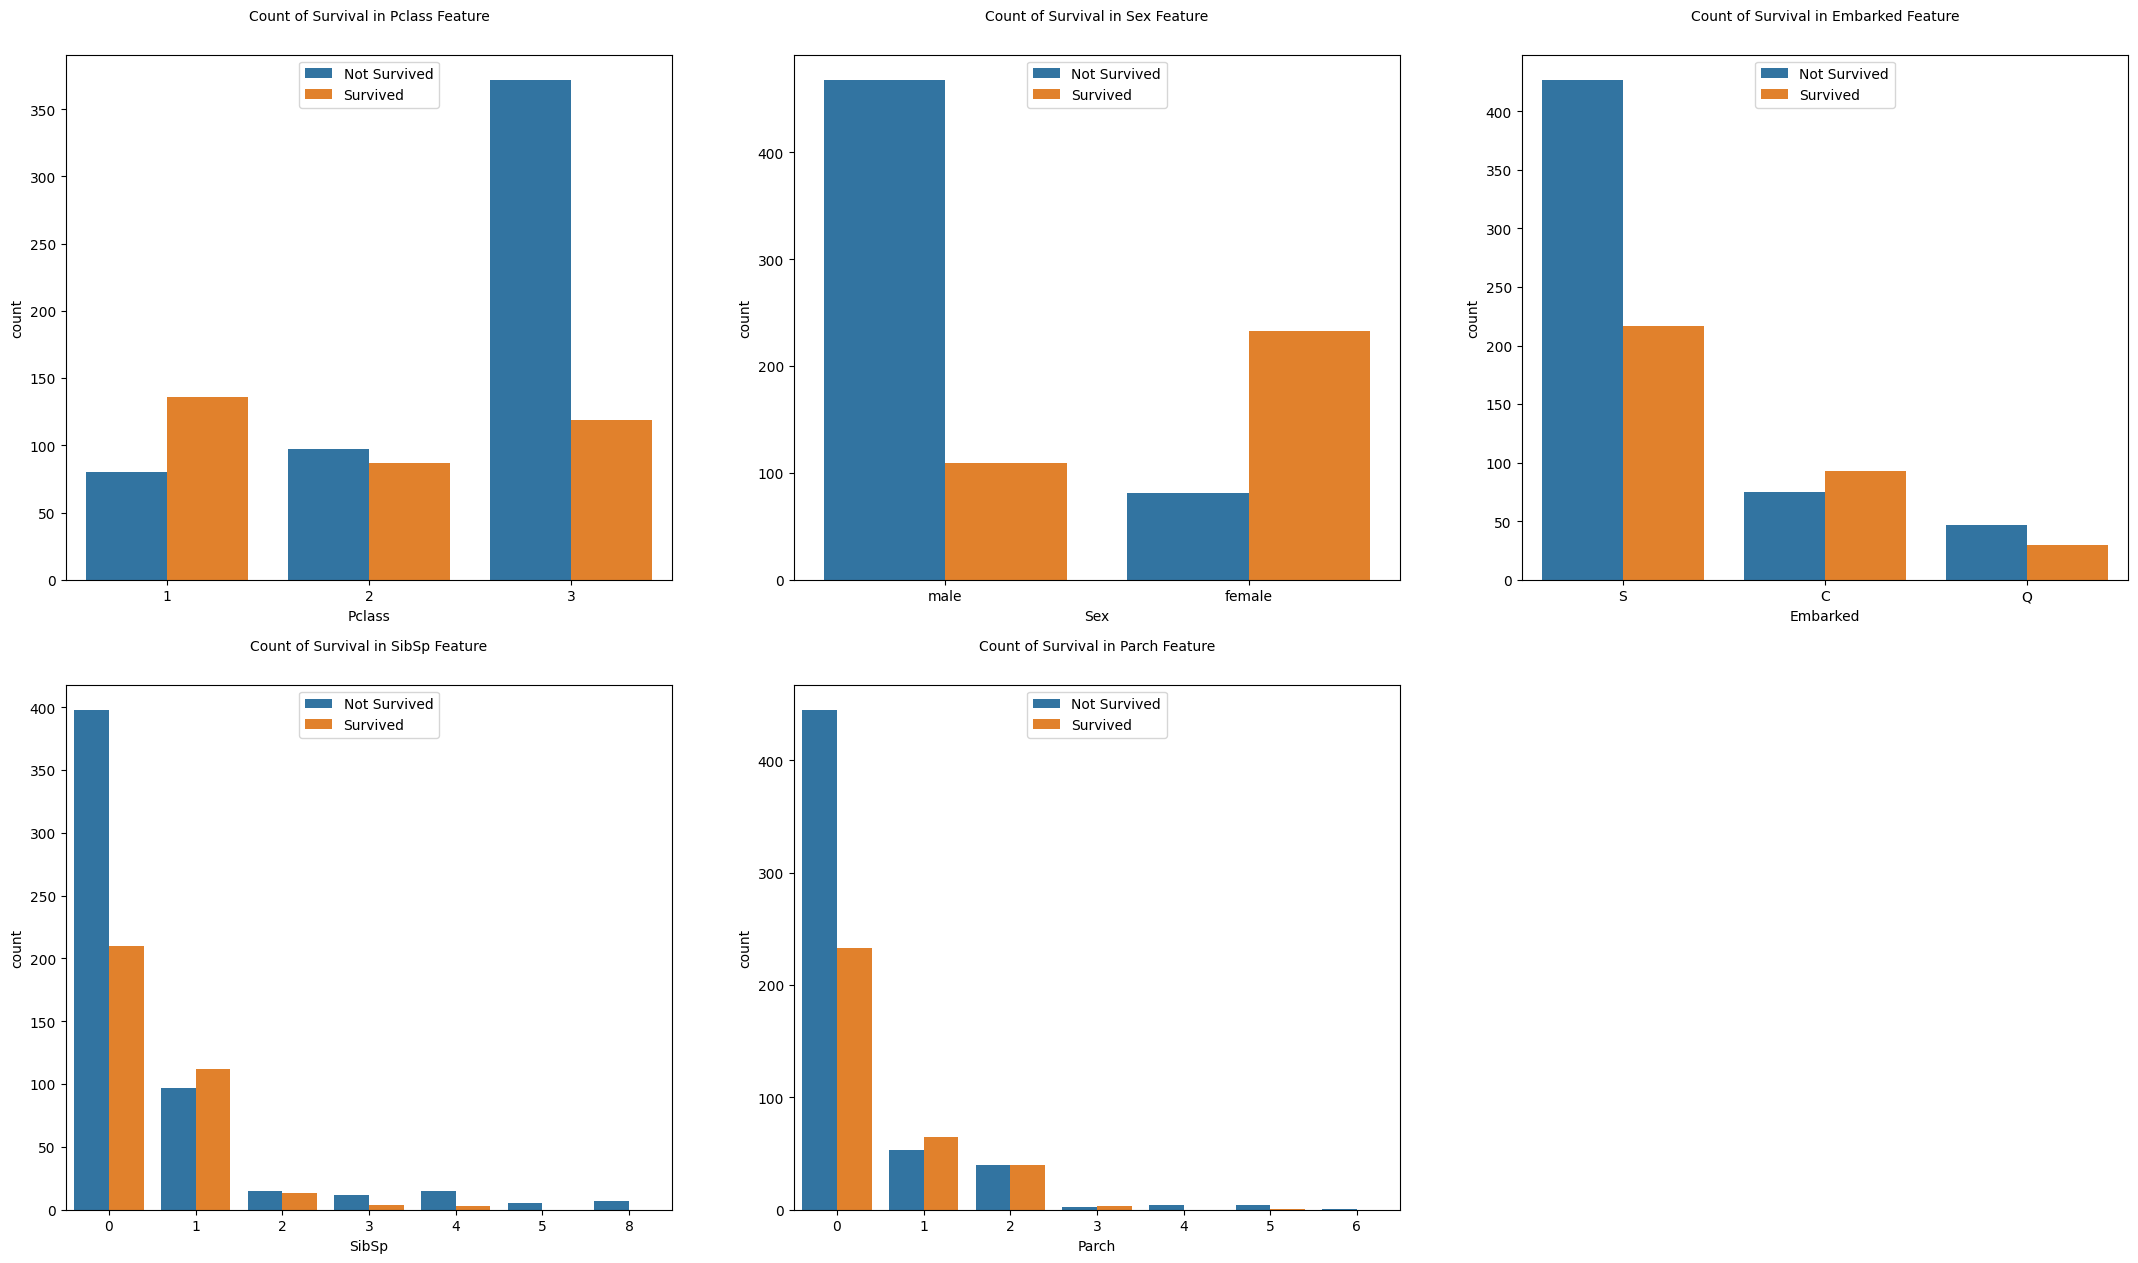

In [10]:
val = ['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch','Cabin']
plt.figure(figsize=(15,15))
plt.subplots_adjust(right=1.5)
for i in range(5):
    plt.subplot(2,3,i+1), sns.countplot(x=val[i], hue='Survived', data = df1)
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 10})
    plt.title('Count of Survival in {} Feature'.format(val[i]), size=10, y=1.05)

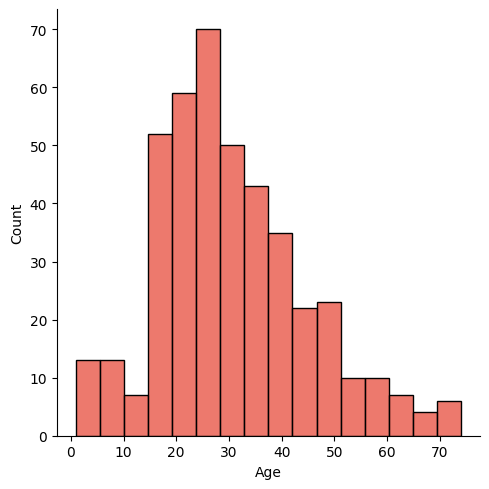

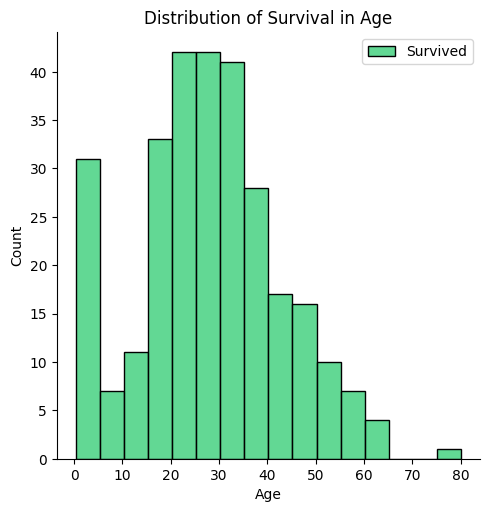

In [16]:
surv = df1['Survived'] == 1


sns.displot(df1[~surv]['Age'], label='Not Survived',  color='#e74c3c')
sns.displot(df1[surv]['Age'], label='Survived',  color='#2ecc71')

plt.legend()
plt.title('Distribution of Survival in Age')

        
plt.show()

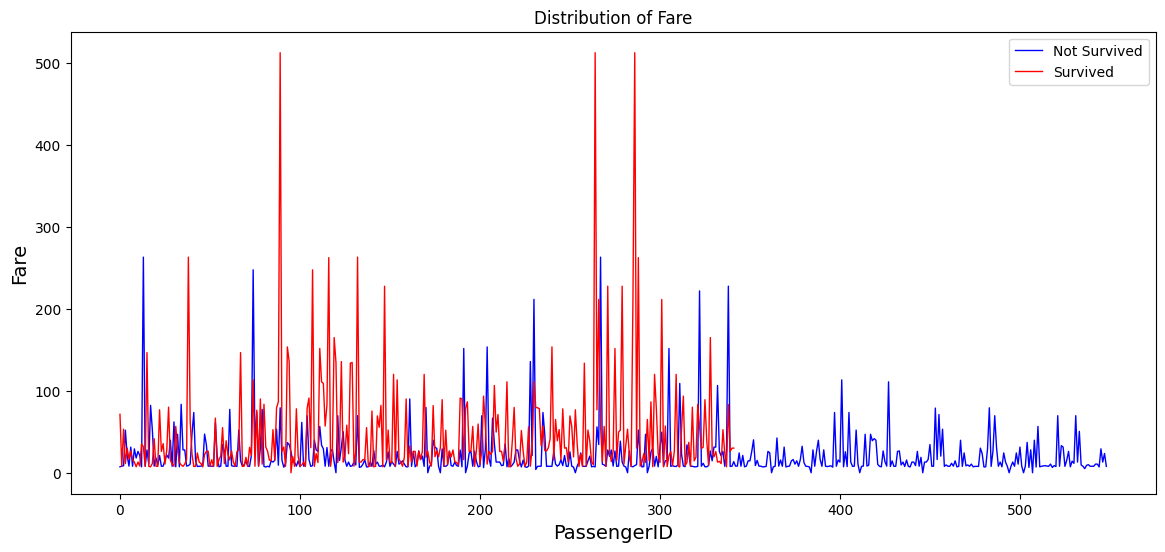

In [17]:
plt.figure(figsize=(14,6))
plt.plot(range(0,len(df1[~surv]['Fare'])), df1[~surv]['Fare'], color='blue', animated=True, linewidth=1)
plt.plot(range(0,len(df1[surv]['Fare'])), df1[surv]['Fare'], color='red', animated=True, linewidth=1)
plt.xlabel('PassengerID', fontsize=14)
plt.ylabel('Fare', fontsize=14)
plt.legend(['Not Survived', 'Survived'])
plt.title('Distribution of Fare')
plt.show()

<a id='5'></a>
# **Feature Engineering**
Basically, all machine learning algorithms use some input data to create outputs. This input data comprise features, which are usually in the form of structured columns. Algorithms require features with some specific characteristic to work properly. Here, the need for feature engineering arises. There maybe be many redundant features which should be eliminated. Also we can get or add new features by observing or extracting information from other features.

We will apply feature engineering steps to both our training and test data. Here we are going to concat them so that we don't have to apply each steps separately. Then later on after applying feature engineering process we will separate them.


In [18]:
df = pd.concat([df1,df2],ignore_index=True)

In [19]:
df.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

**Now we will make a new column which will store the values of number of person in a family and another column which will tell whether the person is alone or not. Then, we will visualize it so that we can check if survival rate have anything to do with family size of the passengers.**

In [20]:
df['Family'] = df['SibSp'] + df['Parch'] + 1
df['Alone'] = df['Family'].apply(lambda x : 0 if x>1 else 1 )

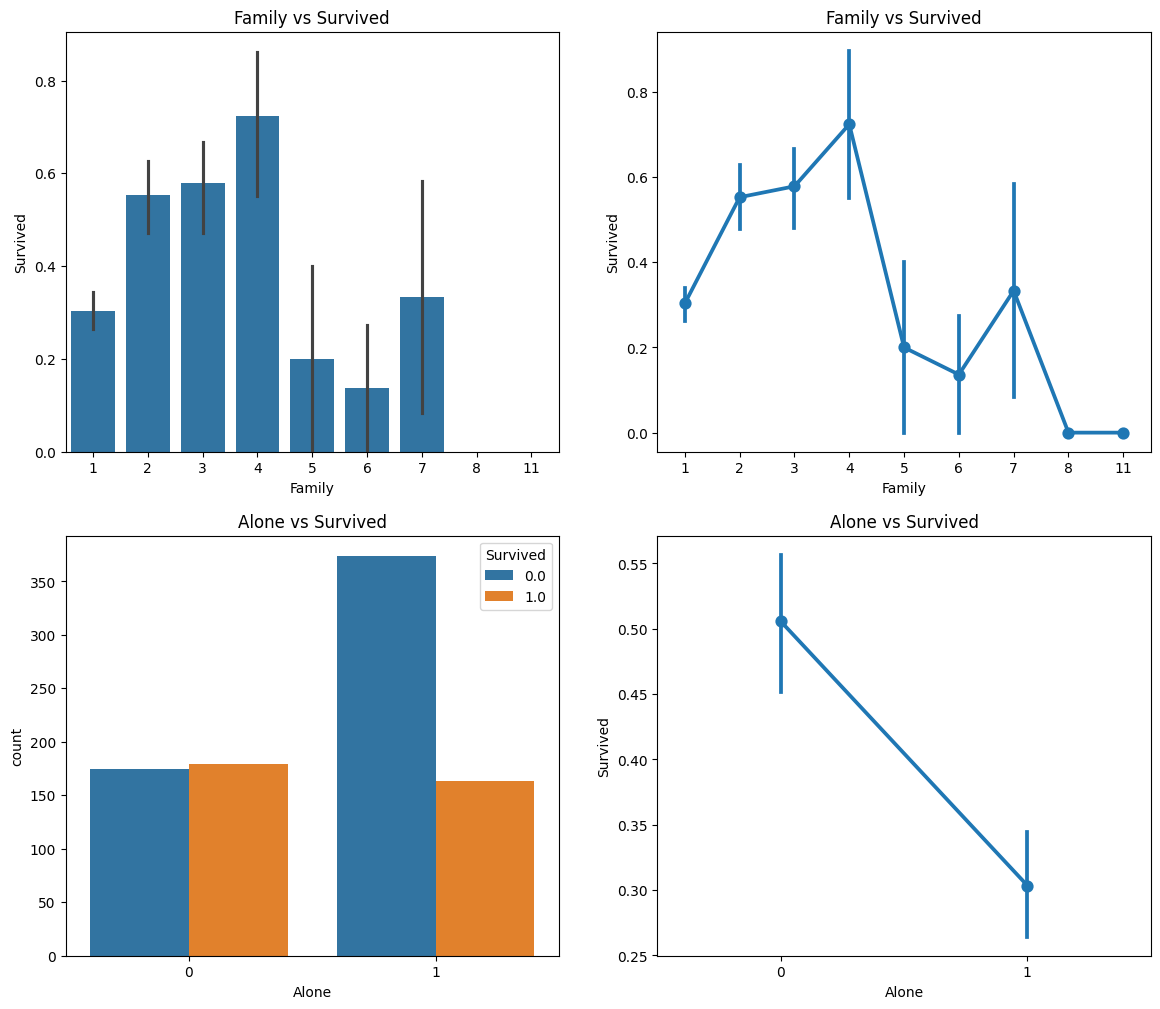

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
sns.barplot(x='Family', y='Survived', data=df, ax=ax[0][0])
ax[0][0].set_title('Family vs Survived')
sns.pointplot(x='Family', y='Survived', data=df, ax=ax[0][1])
ax[0][1].set_title('Family vs Survived')
sns.countplot(x='Alone', hue='Survived', data=df, ax=ax[1][0])
ax[1][0].set_title('Alone vs Survived')
sns.pointplot(x='Alone', y='Survived', data=df, ax=ax[1][1])
ax[1][1].set_title('Alone vs Survived')
plt.show()


**After calculating family size, now we will go to Name column which we haven't seen yet. Although the whole name doesn't make any sense that it will affect the survival rate but the title like Mr., Mrs. etc can affect it. So we will make a new column which will store title of every name.**

In [26]:
df['Title'] = df['Name'].apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))

In [27]:
df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

**Now, we will identify the social status of each title.**

In [28]:
Title_Dictionary = {
        "Capt":       "Officer",
        "Col":        "Officer",
        "Major":      "Officer",
        "Dr":         "Officer",
        "Rev":        "Officer",
        "Jonkheer":   "Royalty",
        "Don":        "Royalty",
        "Sir" :       "Royalty",
        "Countess":   "Royalty",
        "Dona":       "Royalty",
        "Lady" :      "Royalty",
        "Mme":        "Mrs",
        "Ms":         "Mrs",
        "Mrs" :       "Mrs",
        "Mlle":       "Miss",
        "Miss" :      "Miss",
        "Mr" :        "Mr",
        "Master" :    "Master"
                   }
    
# we map each title to correct category
df['Title'] = df['Title'].map(Title_Dictionary)
df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Royalty', 'Officer'], dtype=object)

<AxesSubplot: xlabel='Title', ylabel='count'>

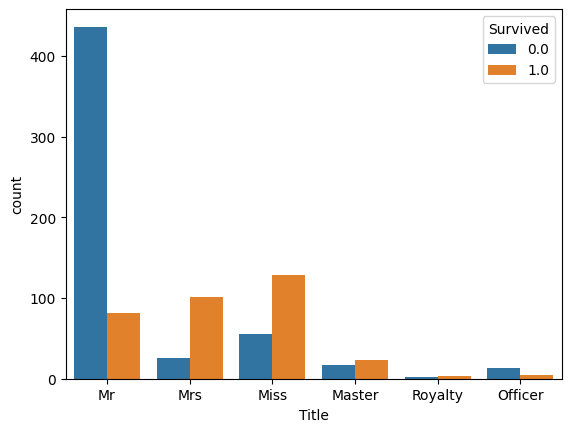

In [29]:
sns.countplot(x='Title', hue='Survived', data = df)

**Now we will fill the null values in the Age column. As we have observed, the Age column has many different values so we can fill it by the mean of all the ages but here I am just filling it with -0.5.**

In [30]:
df['Age'] = df['Age'].fillna(-0.5)

**As we have observed, the graph of Fare column shows that although Fare column have many different values but most of the values are around the median. So we will fill all the null values with the median of the Fare column. Since fare is also a continous feature, we need to convert it into ordinal value.**

In [31]:
df['Fare'] = df['Fare'].fillna(df['Fare'].median())
#intervals to categorize
quant = (-1, 0, 8, 15, 31, 600)

#Labels without input values
label_quants = ['NoInf','quart_1', 'quart_2', 'quart_3', 'quart_4']

#doing the cut in fare and puting in a new column
df["Fare_cat"] = pd.cut(df['Fare'], quant, labels=label_quants)

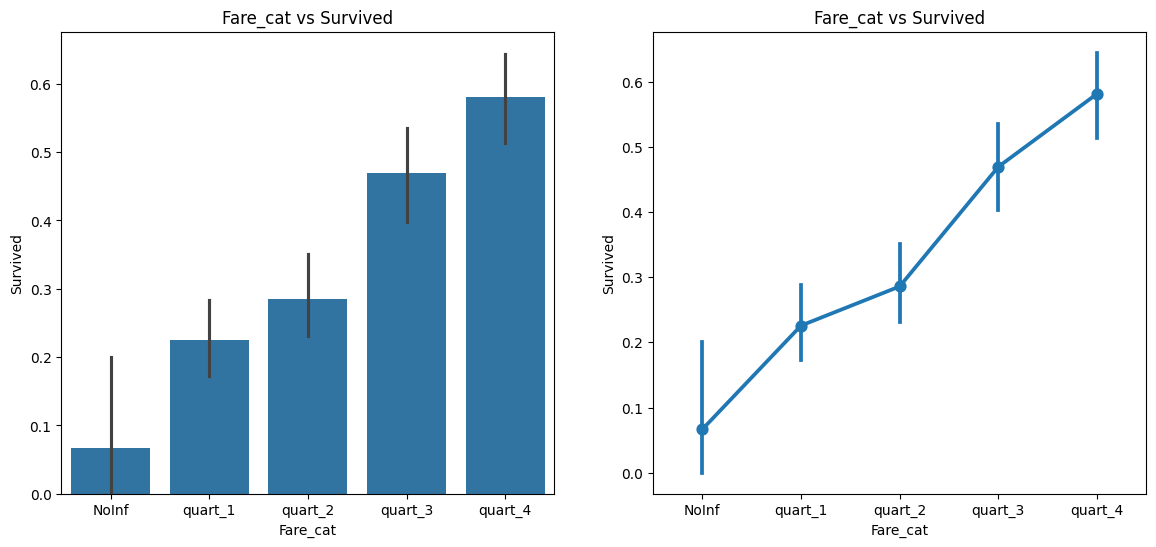

In [33]:
fig ,ax=plt.subplots(1,2,figsize=(14,6))
sns.barplot(x='Fare_cat',y='Survived',data=df,ax=ax[0])
ax[0].set_title('Fare_cat vs Survived')
sns.pointplot(x='Fare_cat',y='Survived',data=df,ax=ax[1])
ax[1].set_title('Fare_cat vs Survived')
plt.close(2)
plt.show()

**Lastly we will fill all the null values in Embarked column with the value which has occured maximum in the data.**

<AxesSubplot: xlabel='Embarked', ylabel='count'>

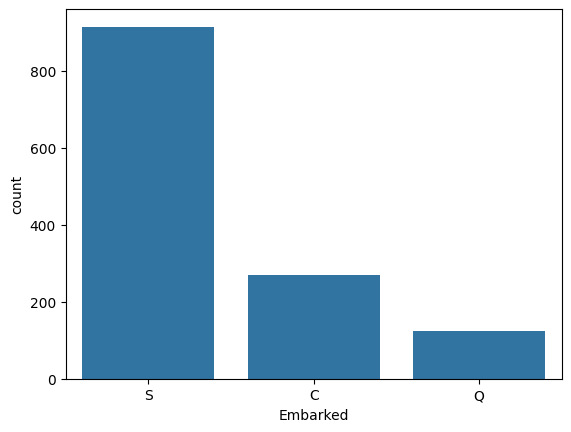

In [35]:
sns.countplot(x='Embarked', data=df)

**So as 'S' as occured most of the time so we will fill it with 'S'.**

In [36]:
df["Embarked"] = df["Embarked"].fillna('S')

In [37]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Alone,Title,Fare_cat
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,Mr,quart_1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0,Mrs,quart_4
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,Miss,quart_1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,0,Mrs,quart_4
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1,Mr,quart_2


**Also, we will drop the columns which we don't require.**

In [38]:
df = df.drop(['Name','Ticket', 'Cabin'], axis=1)

**Now as we have applied all the feature engineering steps so now its time to separate our data back.**

In [39]:
dfs = np.split(df, [len(df1)], axis=0)

In [40]:
train = dfs[0]
train.shape

(891, 13)

In [41]:
test = dfs[1]
del test['Survived']
test.shape

(418, 12)

<a id='6'></a>
# **Spark ML Models**
So now it's time to create our models. Spark ML is a package which aims to provide a uniform set of high-level APIs that help users create and tune practical machine learning pipelines. Spark ML standardizes APIs for machine learning algorithms to make it easier to combine multiple algorithms into a single pipeline, or workflow.<br> ***Here as we are using pyspark to create our models, we first have to convert our data from pandas frame to spark frame.***

In [42]:
train = sqlContext.createDataFrame(train)

**As some of the column contains values in string format so first we indexed them using StringIndexer. A StringIndexer will assign unique integer number to each unique string values.**

In [43]:
indexer = StringIndexer(inputCol='Sex',outputCol='label1')
indexer2 = StringIndexer(inputCol='Embarked',outputCol='label2')
indexer3 = StringIndexer(inputCol='Fare_cat',outputCol='label3')
indexer4 = StringIndexer(inputCol='Title',outputCol='label4')

**Then data is converted which are required to predict survival into vector form by using VectorAssembler as VectorAssembler is a transformer that combines a given list of columns into a single vector column. It is useful for combining raw features and features generated by different feature transformers into a single feature vector, in order to train ML models.<br>Normalizer is a Transformer which transforms a dataset of Vector rows, normalizing each Vector to have unit norm. It takes parameter p, which specifies the p-norm used for normalization. This normalization can help standardize your input data and improve the behavior of learning algorithms.  So then we normalize our data by using Normalizer.**

In [48]:
vector = VectorAssembler(inputCols=['label1','Pclass','Age','label2','Family','label3','label4', 'Alone'],outputCol='features')
normalizer = Normalizer(inputCol='features',outputCol='features_norm', p=1.0)

**Then we call our model and give the input and the output column. Here, the input column will be our normalized data and the output column is what we have to predict i.e. Survived.**

In [52]:
lor = LogisticRegression(featuresCol='features_norm', labelCol='Survived', maxIter=10)

**Now it's time to call  pipeline. MLlib standardizes APIs for machine learning algorithms to make it easier to combine multiple algorithms into a single pipeline, or workflow. So we add all the commands which we have called till now and add them to pipeline.**

In [53]:
pipeline1 = Pipeline(stages=[indexer,indexer2,indexer3,indexer4,vector,normalizer,lor])

**Next, we will fit our pipeline and create a model. This method is called Estimator. An Estimator abstracts the concept of a learning algorithm or any algorithm that fits or trains on data. Technically, an Estimator implements a method fit(), which accepts a DataFrame and produces a Model, which is a Transformer. For example, a learning algorithm such as LogisticRegression is an Estimator, and calling fit() trains a LogisticRegressionModel, which is a Model and hence a Transformer.**

In [54]:
model1 = pipeline1.fit(train)

Py4JJavaError: An error occurred while calling o54.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 18 in stage 1.0 failed 1 times, most recent failure: Lost task 18.0 in stage 1.0 (TID 38) (host.docker.internal executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:713)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:757)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 37 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:713)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:757)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 37 more


**Finally we perform transform function which is known as transformer. A Transformer is an abstraction that includes feature transformers and learned models. Technically, a Transformer implements a method transform(), which converts one DataFrame into another, generally by appending one or more columns.**

In [37]:
predictions1 = model1.transform(train)

**For comparsion of different models we are initializing one list which will store accuracy of all the models.**

In [38]:
accuracy = []

**Using MulticlassClassificationEvaluator we will get the accuracy of our model.**

In [39]:
eval = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('Survived').setPredictionCol('prediction')
print("The accuracy is: " + str(eval.evaluate(predictions1)))
accuracy.append(eval.evaluate(predictions1))

The accuracy is: 0.819304152637486


**The second classification method is GBTClassifier. We have to almost repeat the same steps as we did previously and just have to change the name of model and pipeline and call the gbtclassifier and check the accuracy of the model.**

In [40]:
gbt = GBTClassifier(featuresCol='features_norm',labelCol='Survived',maxIter=100)
pipeline2 = Pipeline(stages=[indexer,indexer2,indexer3,indexer4,vector,normalizer,gbt])
model2 = pipeline2.fit(train)
predictions2 = model2.transform(train)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('Survived').setPredictionCol('prediction')
print("The accuracy is: " + str(eval.evaluate(predictions2)))
accuracy.append(eval.evaluate(predictions2))

The accuracy is: 0.9450056116722784


**The third classification method is Linear Support Vector Classifier.**

In [41]:
svc = LinearSVC(featuresCol='features_norm', labelCol='Survived', maxIter=10)
pipeline3 = Pipeline(stages=[indexer,indexer2,indexer3,indexer4,vector,normalizer,svc])
model3 = pipeline3.fit(train)
predictions3 = model3.transform(train)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('Survived').setPredictionCol('prediction')
print("The accuracy is: " + str(eval.evaluate(predictions3)))
accuracy.append(eval.evaluate(predictions3))

The accuracy is: 0.7856341189674523


**The fourth classification method is DecisionTreeClassifier.**

In [42]:
dt = DecisionTreeClassifier(featuresCol='features_norm', labelCol='Survived')
pipeline4 = Pipeline(stages=[indexer,indexer2,indexer3,indexer4,vector,normalizer,dt])
model4 = pipeline4.fit(train)
predictions4 = model4.transform(train)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('Survived').setPredictionCol('prediction')
print("The accuracy is: " + str(eval.evaluate(predictions4)))
accuracy.append(eval.evaluate(predictions4))

The accuracy is: 0.8496071829405163


**The fifth classification method is RandomForestClassifier.**

In [43]:
rfc = RandomForestClassifier(featuresCol='features_norm', labelCol='Survived')
pipeline5 = Pipeline(stages=[indexer,indexer2,indexer3,indexer4,vector,normalizer,rfc])
model5 = pipeline5.fit(train)
predictions5 = model5.transform(train)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('Survived').setPredictionCol('prediction')
print("The accuracy is: " + str(eval.evaluate(predictions5)))
accuracy.append(eval.evaluate(predictions5))

The accuracy is: 0.8451178451178452


**The sixth classification method is  MultilayerPerceptronClassifier. This method is little different as here we have to provide it with layers also. For eg. here we give layers = [8, 5, 4, 2], where 8 demonstrate number of input features, 5 and 4 are genral middle layers and 2 is number of output classes. According to yor model you should define layers.**

In [44]:
layers = [8, 5, 4, 2]
trainer = MultilayerPerceptronClassifier(featuresCol='features_norm', labelCol='Survived', maxIter=100, layers=layers, blockSize=128, seed=1234)
pipeline6 = Pipeline(stages=[indexer,indexer2,indexer3,indexer4,vector,normalizer,trainer])
model6 = pipeline6.fit(train)
predictions6 = model6.transform(train)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('Survived').setPredictionCol('prediction')
print("The accuracy is: " + str(eval.evaluate(predictions6)))
accuracy.append(eval.evaluate(predictions6))

The accuracy is: 0.8237934904601572


**Now let us compare our models through visualization.**

In [45]:
names = ['Logistic Regression', 'GBTClassifier', 'LinearSVC', 'DecisionTreeClassifier', 'RandomForestClassifier', 'MultilayerPerceptronClassifier']

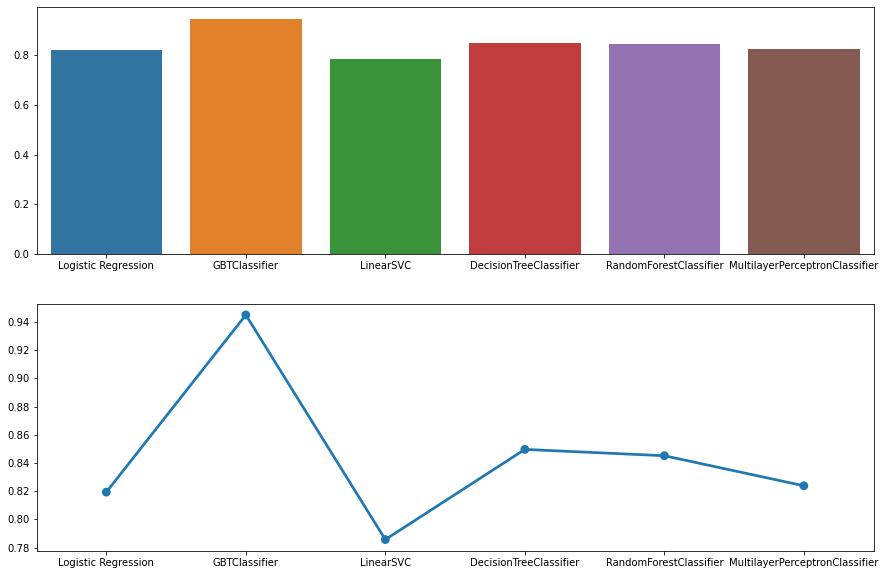

In [46]:
fig, ax = plt.subplots(2,1, figsize=(15,10))
sns.barplot(x=names, y=accuracy, ax=ax[0])
sns.pointplot(x=names, y=accuracy, ax=ax[1])
plt.show()

**As we have observed that GBTClasifer method has the highest accuracy so now let us see some of the predictions through by GBTClassifer method.**

In [47]:
predictions2.select("Survived", "prediction").show()

+--------+----------+
|Survived|prediction|
+--------+----------+
|     0.0|       0.0|
|     1.0|       1.0|
|     1.0|       1.0|
|     1.0|       1.0|
|     0.0|       0.0|
|     0.0|       0.0|
|     0.0|       0.0|
|     0.0|       0.0|
|     1.0|       1.0|
|     1.0|       1.0|
|     1.0|       1.0|
|     1.0|       1.0|
|     0.0|       0.0|
|     0.0|       0.0|
|     0.0|       0.0|
|     1.0|       1.0|
|     0.0|       0.0|
|     1.0|       1.0|
|     0.0|       0.0|
|     1.0|       1.0|
+--------+----------+
only showing top 20 rows



**Now its time to apply our trained model to our test data. We will do this by appling transform method and we will use GBTClassifier model because it has the highest accuracy.**

In [48]:
test = sqlContext.createDataFrame(test)
predictions = model2.transform(test)
predictions = predictions.toPandas()

In [49]:
predictions = model5.transform(test)
predictions = predictions.toPandas()

<a id='7'></a>
# **Submitting the predictions**

In [50]:
sub_df['Survived'] = predictions['prediction']
sub_df.head()

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,1.0


In [51]:
sub_df.to_csv('submission.csv', index=False)

**So we come to an end. I hope I have tried to explain each and every thing. But if you still want to know anything do comment and I will definitely try to solve your doubt.<br> Also, if you want to know more about Spark ML and some other different techniques and methods you can view my another notebook: -** <a href = "https://www.kaggle.com/utcarshagrawal/water-quality-prediction-using-sparkml/notebook" class = "btn btn-info btn-lg active"  role = "button" style = "color: white;" data-toggle = "popover" title = "Click">Click here</a> 
### <font color = 'red'> Thanks a lot for having a look at this notebook. I would like to get an appreciation from you with an upvote. Please upvote if you liked the kernel.</font>